# 충청북도교육연구정보원 코인 주식 투자 (초단타!)

## 환경 코드 정의하기

In [1]:
import numpy as np


class CoinEnv:
    def __init__(self, start_price=10000, max_purchase=10, episode_len=100):
        self.action_space = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        self.max_purchase = max_purchase
        self.start_price = start_price
        self.episode_len = episode_len

    def _find_min_index(self, array):
        assert set(array) != {None}
        min_index = 0
        min_value = +np.inf
        for i in range(len(array)):
            if array[i] == None:
                continue
            if array[i] < min_value:
                min_index = i
                min_value = array[i]
        return min_index

    def reset(self):
        self.current_step = 0
        self.state = [self.start_price] + [None for _ in range(self.max_purchase)]
        return self.state

    def step(self, action):
        current_price = self.state[0]
        current_inventory = self.state[1:]
        reward = 0

        if action[1]: # buy
            if None in current_inventory: # not yet reached the maximum capacity
                index = current_inventory.index(None)
                current_inventory[index] = current_price
            else:
                # print("No more space left for buying! Changing action to 'wait'.")
                pass
        elif action[2]: # sell
            if set(current_inventory) != {None}: # we have something to sell
                index = self._find_min_index(current_inventory)
                bought_price = current_inventory[index]
                reward += (current_price - bought_price)
                current_inventory[index] = None
            else:
                # print("There is noting to sell! Changing action to 'wait'.")
                pass

        direction = np.random.choice([-1, 1])
        current_price += direction
        current_price = max(0, current_price)
        self.state = [current_price] + current_inventory
        self.current_step += 1

        done = (self.current_step >= self.episode_len)
        if done:
            while set(current_inventory) != {None}:
                index = self._find_min_index(current_inventory)
                bought_price = current_inventory[index]
                reward += (current_price - bought_price)
                current_inventory[index] = None

        return self.state, reward, done, {'history': []}


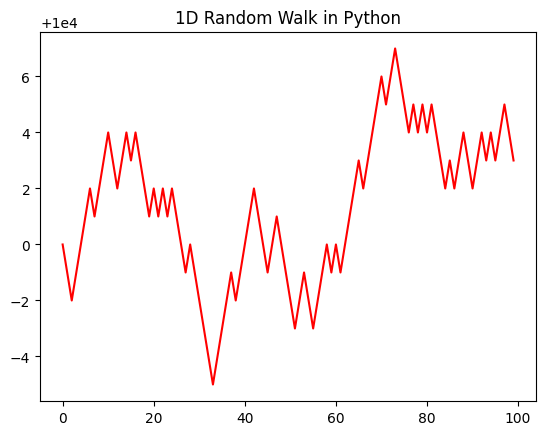

In [2]:
import matplotlib.pyplot as plt


def evaluate():
    timeline = []
    price_history = []

    env = CoinEnv()
    state = env.reset()
    current_price = state[0]
    current_time = 0
    total_reward = 0
    done = False

    while not done:
        timeline.append(current_time)
        price_history.append(current_price)
        action = env.action_space[np.random.randint(3)] # 랜덤한 액션 선택
        state, reward, done, _ = env.step(action)
        current_price = state[0]
        current_time += 1
        total_reward += reward

    return total_reward, timeline, price_history

_, timeline, price_history = evaluate()

plt.plot(timeline, price_history, 'r-')
plt.title("1D Random Walk in Python")
plt.show()

In [3]:
# 랜덤한 액션을 취했을 때의 평균 수익

rewards = []

for _ in range(1000):
    total_reward, _, _ = evaluate()
    rewards.append(total_reward)

print(np.mean(rewards))
print(np.max(rewards))
print(np.min(rewards))

0.075
175
-178


## 나만의 전략을 이용해 평가해보기

In [4]:
def my_strategy(state):
    current_price = state[0]
    current_inventory = state[1:]
    ??????
    return action

def evaluate_my_strategy():
    timeline = []
    price_history = []

    env = CoinEnv()
    state = env.reset()
    current_price = state[0]
    current_time = 0
    total_reward = 0
    done = False

    while not done:
        timeline.append(current_time)
        price_history.append(current_price)
        action = my_strategy(state)
        state, reward, done, _ = env.step(action)
        current_price = state[0]
        current_time += 1
        total_reward += reward

    return total_reward, timeline, price_history

# 내 전략 평가하기
rewards = []

for _ in range(1000):
    total_reward, _, _ = evaluate()
    rewards.append(total_reward)

print(np.mean(rewards))
print(np.max(rewards))
print(np.min(rewards))

1.317
174
-249


## 뉴-럴넷을 사용한 (아주) 간단한 강화학습

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Write neural network code -> 저번 시간에 했던 코드!!
class NeuralNetwork(nn.Module):
    # input_dim: 상태 정보의 크기 (현재 가격 1 + 구매 이력 10)
    # 이때, 구매 이력의 크기는 최대 구매 가능 횟수로 결정함.

    # output_dim: 행동의 크기 (구매하기, 팔기, 기다리기 -> 총 3가지)
    def __init__(self, input_dim=21, output_dim=3, hidden_dim=512, num_layers=3):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = [
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_layers)
        ]
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, mask):
        x= torch.cat([x, mask], dim=-1) # x와 mask를 이어붙이는것
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
          x = layer(x)
          x = self.activation(x)
        x = self.output_layer(x)
        x = F.softmax(x, dim=-1)
        return x

In [11]:
# 상태 정보를 뉴럴넷이 처리할 수 있는 pytorch tensor로 변경.
# (참고: 쌤 환경 코드는 구매 가능 빈 슬롯을 None으로 했으므로, 아래 코드가 필요)
def parse_state(state, start_price=10000, normalization_constant=10):
    current_price = np.array([state[0]])
    current_inventory = np.array(state[1:])

    # 마스크를 생성
    # 구매한 index는 1, 비어있는 index는 0을 출력
    mask = np.ones_like(current_inventory)
    mask_index = np.where(current_inventory == None)
    mask[mask_index] = 0
    mask = torch.tensor(mask.astype(np.float32)) # 파이토치 텐서로 변경

    current_inventory[mask_index] = start_price
    state = np.concatenate([current_price, current_inventory])
    state = torch.tensor(state.astype(np.float32)) # 파이토치 텐서로 변경
    state -= start_price # Normalization - 표준화
    state /= normalization_constant
    return state, mask

# 보상 함수를 따로 정의
# 지도 학습의 오차 함수 (loss function)의 역할을 수행할 수 있도록 하기 위함.
class RewardFunction(nn.Module):
    def __init__(self):
        super(RewardFunction, self).__init__()

    def forward(self, state, action, mask, done):
        current_price = state[0]
        inventory = state[1:]

        current_price = current_price.float()
        inventory = inventory.float()
        mask = mask.float()

        reward = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

        if action[2] == 1:  # Sell action
            if mask.sum() > 0:  # We have something to sell
                valid_inventory = inventory * mask
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward = reward + (current_price - min_value) * mask[min_index]

        if done:
            valid_inventory = inventory * mask
            while mask.sum() > 0:
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward = reward + (current_price - min_value).sum()
                mask[min_index] = 0

        return reward

Total Reward: 0.29999998956918716
Total Reward: 2.000000014901161
Total Reward: 4.199999921023846
Total Reward: 0.20000001788139343
Total Reward: -3.2999998927116394
Total Reward: 1.2000000923871994
Total Reward: 2.100000075995922
Total Reward: 0.4000000134110451
Total Reward: 1.5999996215105057
Total Reward: 0.799999937415123
Total Reward: 0.8000000417232513
Total Reward: 0.8000000193715096
Total Reward: -3.5000001341104507
Total Reward: -0.10000003129243851
Total Reward: 0.9000000208616257
Total Reward: -0.30000001192092896
Total Reward: 1.7000000178813934
Total Reward: 4.8000001311302185
Total Reward: 2.200000010430813
Total Reward: 0.20000000298023224
Total Reward: -0.30000007152557373
Total Reward: -1.4000000655651093
Total Reward: 5.3999999538064
Total Reward: 4.800000101327896
Total Reward: 0.0
Total Reward: -0.20000004768371582
Total Reward: 0.10000001639127731
Total Reward: -4.199999928474426
Total Reward: 0.3000001460313797
Total Reward: 0.30000001192092896
Total Reward: 0.10

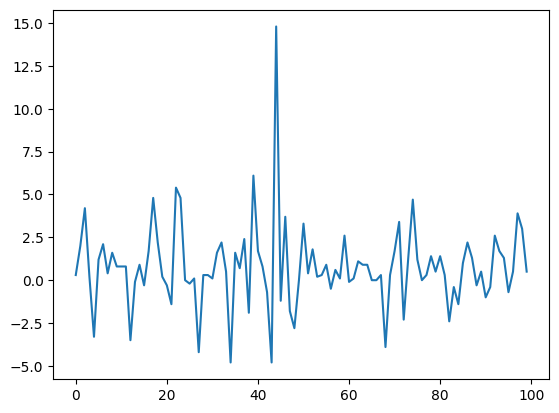

: 

In [12]:
def train(num_epochs=100):

    model = NeuralNetwork() # 모델 정의
    reward_function = RewardFunction() # 보상 함수를 정의

    optimizer = torch.optim.Adam(model.parameters(), lr=0.02) # 뉴럴넷의 학습을 위해 필요한 부분


    reward_curve = []
    for epoch in range(num_epochs):
        env = CoinEnv()
        state = env.reset()
        current_price = state[0]
        current_time = 0
        total_reward = 0

        done = False

        while not done:
            timeline.append(current_time)
            price_history.append(current_price)
            state, mask = parse_state(state)

            # 지도 학습에서 사용한 뉴럴넷 학습 코드
            # 전체적인 구조는 동일!
            '''
            optimizer.zero_grad() # (1)
            output = network(x) # (2)
            loss = loss_function(y, output) # (3)
            loss.backward() # (4)
            optimizer.step() # (5)
            '''

            optimizer.zero_grad() # (1)

            logits = model(state, mask) # (2)
            # logit은 모델이 생각하는 행동에 대한 확률
            # 가장 큰 확률값을 선택하는 행동
            # argmax_index = torch.argmax(logits)
            # num_classes = logits.size(0)
            # action = F.one_hot(argmax_index, num_classes)

            # 아래는 확률에 따라 행동을 랜덤하게 선택하게 하는 코드
            m = torch.distributions.Categorical(logits=logits)
            action_index = m.sample()
            num_classes = logits.size(0)
            action = F.one_hot(action_index, num_classes).float()

            reward = reward_function(state, action, mask, done) # (3)
            loss = -reward # (3)

            loss.backward() # (4)
            optimizer.step() # (5)

            state, _, done, _ = env.step(action)
            current_price = state[0]
            current_time += 1
            total_reward += reward.item()

        print(f"Total Reward: {total_reward}")
        reward_curve.append(total_reward)

    plt.plot(reward_curve)
    plt.show()

train()
